In [1]:
import msprime, pyslim
import tskit
import json
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import itertools
import math

import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import os
import gpustat
import pandas as pd
from torch.utils.data import DataLoader, random_split, TensorDataset
from torch import nn
from torchvision.io import read_image
import torchvision.transforms as transforms

import sklearn
import sklearn.model_selection

rng = np.random.default_rng()

In [2]:
stats = gpustat.GPUStatCollection.new_query()
ids = map(lambda gpu: int(gpu.entry['index']), stats)
ratios = map(lambda gpu: float(gpu.entry['memory.used'])/float(gpu.entry['memory.total']), stats)
bestGPU = min(zip(ids, ratios), key=lambda x: x[1])[0]
os.environ['CUDA_VISIBLE_DEVICES'] = str(bestGPU)
print(stats)

GPUStatCollection(host=poppy, [
  [0] NVIDIA A100 80GB PCIe | 29°C,   0 % |     0 / 81920 MB |
  [1] NVIDIA A100 80GB PCIe | 27°C,   0 % |     0 / 81920 MB |
  [2] NVIDIA A100 80GB PCIe | 28°C,   0 % |     0 / 81920 MB |
])


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [4]:
base_folder = "bearded_seals"
labels = pd.read_csv(base_folder + "/labels.csv")
print(labels)

        R0  rep  bias         N_avg     n  npairs
0     8.52    1   1.0   3699.047619  2000     264
1     8.52    1  15.5   3699.047619  2050     291
2     8.52    1  30.0   3699.047619  2050     305
3     8.52    2   1.0   3837.714286  2000     223
4     8.52    2  15.5   3837.714286  2050     278
...    ...  ...   ...           ...   ...     ...
7645  9.90   49  15.5  17042.904762  2050      70
7646  9.90   49  30.0  17042.904762  2050      69
7647  9.90   50   1.0  15135.619048  2000      41
7648  9.90   50  15.5  15135.619048  2050      66
7649  9.90   50  30.0  15135.619048  2050      62

[7650 rows x 6 columns]


bearded_seals/bearded_seal_images/spaghetti_8.52_1_1.0_2000.png
bearded_seals/bearded_seal_images/sampling_intensity_8.52_1_1.0_2000.png


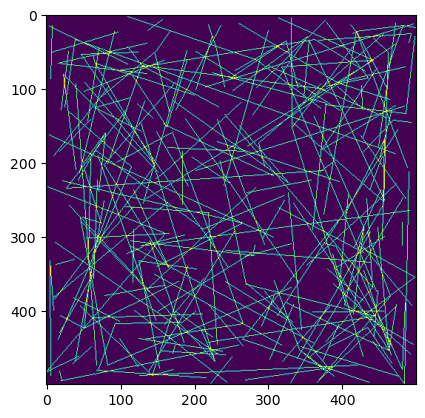

In [5]:
idx = 0
row = labels.iloc[idx,]
R0 = row.loc['R0']
rep = int(row.loc['rep'])
bias = row.loc['bias']
n = int(row.loc['n'])
spaghetti_path = f'{base_folder}/bearded_seal_images/spaghetti_{R0}_{rep}_{bias}_{n}.png'
print(spaghetti_path)
spaghetti = read_image(spaghetti_path)
intensity_path = f'{base_folder}/bearded_seal_images/sampling_intensity_{R0}_{rep}_{bias}_{n}.png'
print(intensity_path)
intensity = read_image(intensity_path)
plt.imshow(spaghetti[0])

In [6]:
print(spaghetti.size())
print(intensity.size())
images = torch.cat((spaghetti, intensity), 0)
print(images.size())

torch.Size([1, 500, 500])
torch.Size([1, 500, 500])
torch.Size([2, 500, 500])


In [7]:
class KinDataset(Dataset):
    def __init__(self, base_folder, labels_file):
        self.labels = pd.read_csv(base_folder + "/" + labels_file)
        self.base_folder = base_folder
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        row = self.labels.iloc[idx,]
        R0 = row.loc['R0']
        rep = int(row.loc['rep'])
        bias = row.loc['bias']
        n = int(2000)
        spaghetti_path = f'{self.base_folder}/bearded_seal_images/spaghetti_{R0}_{rep}_{bias}_{n}.png'
        spaghetti = read_image(spaghetti_path)
        intensity_path = f'{self.base_folder}/bearded_seal_images/sampling_intensity_{R0}_{rep}_{bias}_{n}.png'
        intensity = read_image(intensity_path)
        input_tensor = torch.cat((spaghetti, intensity), 0).float()
        label = torch.tensor([self.labels['N_avg'].iloc[idx]]).float()
        return input_tensor, label
    
kin_dataset = KinDataset("bearded_seals", "labels.csv")

In [8]:
print(kin_dataset[2][0].size())
print(kin_dataset[2][1])
print(kin_dataset[100][1])

torch.Size([2, 500, 500])
tensor([3699.0476])
tensor([3818.7620])


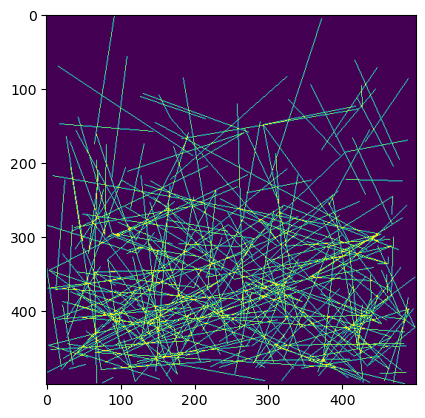

In [9]:
plt.imshow(kin_dataset[2][0][0])

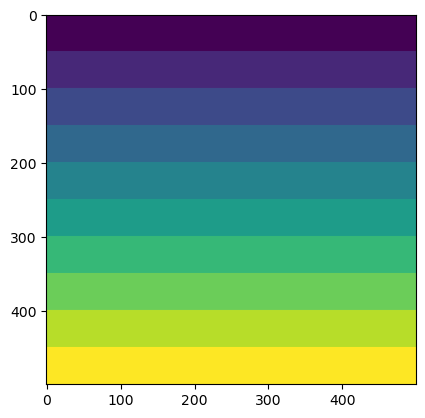

In [10]:
plt.imshow(kin_dataset[2][0][1])

In [11]:
n_total = len(kin_dataset)
n_train = round(n_total*0.5)
n_valid = round((n_total-n_train)*0.5)
n_test = n_total-n_train-n_valid

In [12]:
train_kin, valid_kin, test_kin = random_split(kin_dataset, [n_train, n_valid, n_test], generator=torch.Generator().manual_seed(42))

batch_size = 64
train_kin_dl = DataLoader(train_kin, batch_size, shuffle = True)
valid_kin_dl = DataLoader(valid_kin, batch_size, shuffle = True)
test_kin_dl = DataLoader(test_kin, batch_size, shuffle = True)
print(len(train_kin))
print(len(valid_kin))
print(len(test_kin))

3825
1912
1913


In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(1000000, 1024)
        self.fc2 = nn.Linear(1024, 1)
        self.dropout = nn.Dropout(p=0.2)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten() 
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = Net()
model = model.to(device) 

In [14]:
loss_fn = nn.MSELoss(reduction='mean')

In [15]:
loss_fn = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device) 
            y_batch = y_batch.to(device) 
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)

        loss_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device) 
                y_batch = y_batch.to(device) 
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1} loss: {loss_hist_train[epoch]:.4f} val_loss: {loss_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid

In [33]:
torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs, train_kin_dl, valid_kin_dl)

Epoch 1 loss: 24040738.5807 val_loss: 14080745.9289
Epoch 2 loss: 8800151.6604 val_loss: 6011702.2071
Epoch 3 loss: 3360402.1198 val_loss: 3744682.6925
Epoch 4 loss: 1813110.9566 val_loss: 3179209.7401
Epoch 5 loss: 1432740.9118 val_loss: 3064648.6318
Epoch 6 loss: 933450.2933 val_loss: 2971432.0387
Epoch 7 loss: 727191.2982 val_loss: 2744037.5816
Epoch 8 loss: 582727.4630 val_loss: 2947946.4634
Epoch 9 loss: 491502.4146 val_loss: 2851848.6098
Epoch 10 loss: 454412.2158 val_loss: 2866948.7824
Epoch 11 loss: 330474.1635 val_loss: 2920696.2113
Epoch 12 loss: 335179.3703 val_loss: 3003120.0533
Epoch 13 loss: 431386.6338 val_loss: 2929481.3473
Epoch 14 loss: 291374.0069 val_loss: 2952268.2259
Epoch 15 loss: 233063.4933 val_loss: 2988907.7406
Epoch 16 loss: 232413.6740 val_loss: 3009467.9205
Epoch 17 loss: 387994.7224 val_loss: 3296452.6757
Epoch 18 loss: 240586.1485 val_loss: 3018416.4174
Epoch 19 loss: 227110.6162 val_loss: 3160732.4749
Epoch 20 loss: 275546.2883 val_loss: 3001162.1715


In [35]:
#Save model
PATH = "model.pt"
torch.save(model.state_dict(), PATH)

In [16]:
# Load model
PATH = "model.pt"
model = Net()
model.load_state_dict(torch.load(PATH))
model.eval()

Net(
  (conv1): Conv2d(2, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=1000000, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

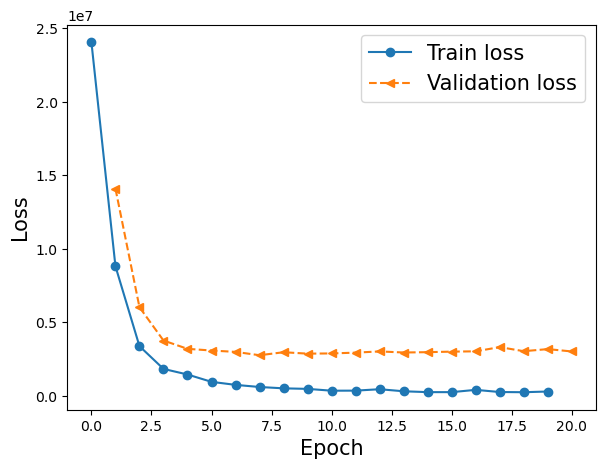

In [36]:
train_x = np.arange(len(hist[0]))
val_x = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(train_x, hist[0], '-o', label='Train loss')
ax.plot(val_x, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)

plt.show()

## Record bias when testing
- Random simulations have maximum sampling intensity of 8
- Bias 15.5 have max intensity 132
- Bias 30 have max intensity 255

In [46]:
torch.cuda.synchronize()
model_cpu = model.cpu()

test_truth = np.empty(len(test_kin))
test_pred = np.empty(len(test_kin))
test_bias = np.empty(len(test_kin))

with torch.no_grad():
    for i, (test_input, test_output) in enumerate(test_kin):
        test_pred[i] = model(test_input.unsqueeze(0))[0][0]
        test_truth[i] = test_output[0]
        test_bias[i] = torch.max(test_input[1]).item()/torch.min(test_input[1]).item()

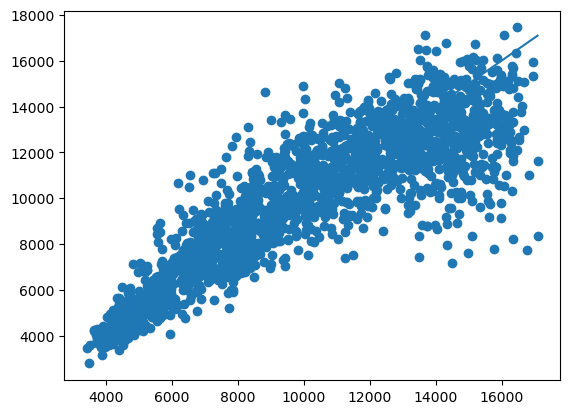

In [47]:
plt.scatter(test_truth, test_pred)
plt.plot([np.min(test_truth), np.max(test_truth)], [np.min(test_truth), np.max(test_truth)])

In [48]:
# Write test results to file
results = {'truth': test_truth, 'bearded_nn_pred': test_pred, 'bias': test_bias}
df = pd.DataFrame(data=results)
df.to_csv("bearded_seals_nn_results/bearded_seals_nn_results.csv", index = False)

tensor(255.)


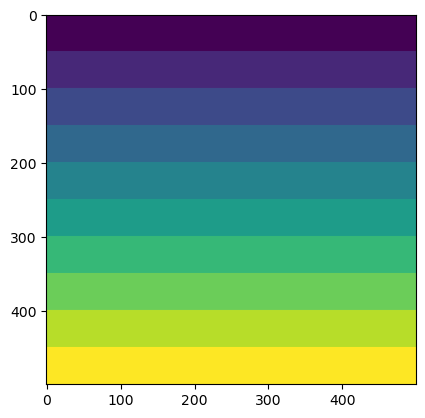

In [40]:
print(torch.max(test_kin[3][0][1]))
plt.imshow(test_kin[3][0][1])

## How well does the previous model work on the bearded seal sims?

In [51]:
# Create a dataset with only sample locations and spaghetti (because this is what the former model took as input)
class SampleDataset(Dataset):
    def __init__(self, base_folder, labels_file):
        self.labels = pd.read_csv(base_folder + "/" + labels_file)
        self.base_folder = base_folder
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        row = self.labels.iloc[idx,]
        R0 = row.loc['R0']
        rep = int(row.loc['rep'])
        bias = row.loc['bias']
        n = int(2000)
        spaghetti_path = f'{self.base_folder}/bearded_seal_images/spaghetti_{R0}_{rep}_{bias}_{n}.png'
        spaghetti = read_image(spaghetti_path)
        intensity_path = f'{self.base_folder}/bearded_seal_images/samples_{R0}_{rep}_{bias}_{n}.png'
        intensity = read_image(intensity_path)
        input_tensor = torch.cat((spaghetti, intensity), 0).float()
        label = torch.tensor([self.labels['N_avg'].iloc[idx]]).float()
        return input_tensor, label
    def __getbias__(self, idx):
        row = self.labels.iloc[idx,]
        bias = row.loc['bias']
        return(bias)

In [52]:
sample_dataset = SampleDataset("bearded_seals", "labels.csv")

In [41]:
n_total = len(sample_dataset)
# Only test on a subset to make computing predictions faster
n_test = 1000
extra_sample, test_sample = random_split(sample_dataset, [n_total-n_test, n_test], generator=torch.Generator().manual_seed(42))
print(n_total)

7650


torch.Size([2, 500, 500])
tensor([12663.3330])
tensor([7201.8569])


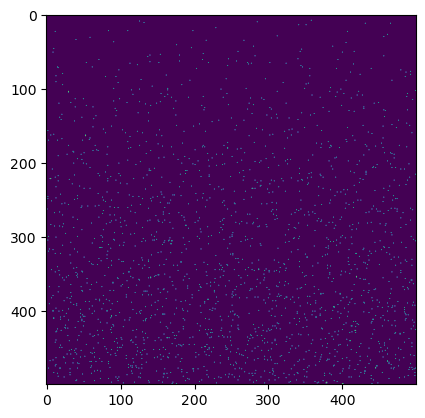

In [42]:
print(test_sample[2][0].size())
print(test_sample[2][1])
print(test_sample[100][1])
plt.imshow(test_sample[2][0][0])
plt.imshow(test_sample[2][0][1])

In [43]:
# Model trained on unbiased sampling
class UnbiasedNet(nn.Module):
    def __init__(self):
        super(UnbiasedNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(1000000, 1024)
        self.fc2 = nn.Linear(1024, 1)
        self.dropout = nn.Dropout(p=0.2)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten() 
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

PATH = "../close_kin_slim/spaghetti_nn_results/first_model.pt"
unbiased_model = UnbiasedNet()
unbiased_model.load_state_dict(torch.load(PATH))
unbiased_model.eval()

UnbiasedNet(
  (conv1): Conv2d(2, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=1000000, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [46]:
# Test model on bearded seal data
torch.cuda.synchronize()
model_cpu = model.cpu()

test_truth = np.empty(len(test_sample))
test_pred = np.empty(len(test_sample))
test_bias = np.empty(len(test_sample))

with torch.no_grad():
    for i, (test_input, test_output) in enumerate(sample_dataset):
        test_pred[i] = model(test_input.unsqueeze(0))[0][0]
        test_truth[i] = test_output[0]

IndexError: index 1000 is out of bounds for axis 0 with size 1000

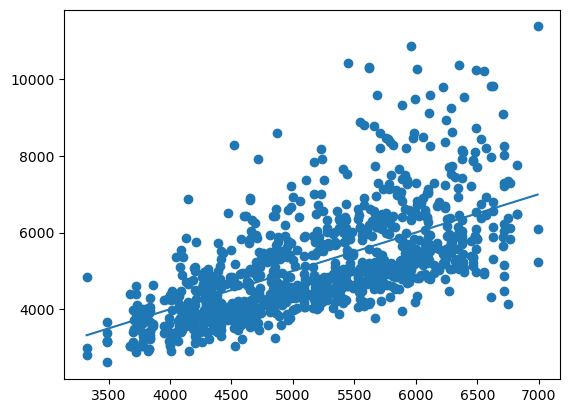

In [ ]:
plt.scatter(test_truth, test_pred)
plt.plot([np.min(test_truth), np.max(test_truth)], [np.min(test_truth), np.max(test_truth)])